Chuyển đổi định dạng tọa độ YOLO

In [1]:
import os
import json
import cv2  # Import thư viện OpenCV
import numpy as np

def convert_bbox_to_yolo(size, bbox):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (bbox[0] + bbox[1]) / 2.0
    y = (bbox[2] + bbox[3]) / 2.0
    w = bbox[1] - bbox[0]
    h = bbox[3] - bbox[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def convert_wildtrack_to_yolo(json_folder, image_folder, output_label_folder):
    if not os.path.exists(output_label_folder):
        os.makedirs(output_label_folder)

    for json_file in os.listdir(json_folder):
        if json_file.endswith(".json"):
            with open(os.path.join(json_folder, json_file), 'r') as f:
                data = json.load(f)
            for person in data:
                person_id = person['personID']
                for view in person['views']:
                    if view['xmin'] != -1:
                        bbox = [view['xmin'], view['xmax'], view['ymin'], view['ymax']]
                        yolo_bbox = convert_bbox_to_yolo((1920, 1080), bbox)
                        
                        label_file = os.path.join(output_label_folder, f'{json_file[:-5]}_C{view["viewNum"]+1}.txt')
                        with open(label_file, 'a') as lf:
                            lf.write(f"0 {person_id} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]}\n")
                        
# Đường dẫn đến các thư mục
json_folder = '/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/annotations_positions'
image_folder = '/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/Image_subsets'
output_label_folder = '/kaggle/working/labels'

convert_wildtrack_to_yolo(json_folder, image_folder, output_label_folder)


Đọc file ảnh và chia tỉ lệ dataset

In [2]:
import random

# for i in range(1, 8):
#     images_path = '/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/Image_subsets'
#     cam_id = 'C'+str(i)
#     full_path = os.path.join(images_path, cam_id)
#     for fname in os.listdir(full_path):
#         fname[:-4] + '.' + cam_id

images_path = '/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/Image_subsets'
C1_files = os.listdir(os.path.join(images_path, 'C1'))
C1_files.sort()
C1_files = C1_files[:-1] # tạm thời: để cùng số lượng file trong thư mục annotations_positions
filenames = []
for filename in C1_files:
    filenames.append(filename[:-4])
print(f'Số lượng tên file: {len(filenames)}')
print(f'5 tên file đầu: {filenames[:5]}')

random.seed(42)
random.shuffle(filenames)
num_files = len(filenames)
train_split = int(0.8 * num_files)
val_split = int(0.1 * num_files)
train_filenames = filenames[:train_split]
val_filenames = filenames[train_split:train_split + val_split]
test_filenames = filenames[train_split + val_split:]
print(f"Số lượng train: {len(train_filenames)} files")
print(f"Số lượng val: {len(val_filenames)} files")
print(f"Số lượng test: {len(test_filenames)} files")

Số lượng tên file: 400
5 tên file đầu: ['00000000', '00000005', '00000010', '00000015', '00000020']
Số lượng train: 320 files
Số lượng val: 40 files
Số lượng test: 40 files


Chia dataset trên ảnh

In [3]:
import shutil

output_image_folder = '/kaggle/working/images'
train_dir = os.path.join(output_image_folder, "train")
val_dir = os.path.join(output_image_folder, "val")
test_dir = os.path.join(output_image_folder, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
images_C1_path = '/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/Image_subsets/C1'
ext = '.png'
for f in train_filenames:
    for c in range(1, 8):
        cam_id = 'C' + str(c)
        shutil.copy(os.path.join(os.path.join(images_path, cam_id), f+ext), os.path.join(train_dir, f+'_'+cam_id+ext))
for f in val_filenames:
    for c in range(1, 8):
        cam_id = 'C' + str(c)
        shutil.copy(os.path.join(os.path.join(images_path, cam_id), f+ext), os.path.join(val_dir, f+'_'+cam_id+ext))
for f in test_filenames:
    for c in range(1, 8):
        cam_id = 'C' + str(c)
        shutil.copy(os.path.join(os.path.join(images_path, cam_id), f+ext), os.path.join(test_dir, f+'_'+cam_id+ext))


Chia dataset trên labels

In [4]:
output_label_folder = '/kaggle/working/labels'
train_dir = os.path.join(output_label_folder, "train")
val_dir = os.path.join(output_label_folder, "val")
test_dir = os.path.join(output_label_folder, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
ext = '.txt'
for f in train_filenames:
    for c in range(1, 8):
        cam_id = 'C' + str(c)
        fname = f+'_'+cam_id+ext
        shutil.move(os.path.join(output_label_folder, fname), os.path.join(train_dir, fname))
for f in val_filenames:
    for c in range(1, 8):
        cam_id = 'C' + str(c)
        fname = f+'_'+cam_id+ext
        shutil.move(os.path.join(output_label_folder, fname), os.path.join(val_dir, fname))
for f in test_filenames:
    for c in range(1, 8):
        cam_id = 'C' + str(c)
        fname = f+'_'+cam_id+ext
        shutil.move(os.path.join(output_label_folder, fname), os.path.join(test_dir, fname))


Produce yaml

In [5]:
yaml_content = """path: /kaggle/working  # dataset root directory
train: images/train  # training images (relative to 'path')
val: images/val  # validation images (relative to 'path')
test: images/test  # optional test images
names:
  0: person
"""

yaml_file_path = "wildtrack.yaml"
with open(yaml_file_path, 'w') as file:
    file.write(yaml_content)


In [6]:
fname = 'wildtrack.zip'
folder_path = '/kaggle/working'
!zip -r {fname} {folder_path} > /dev/null 2>&1

In [7]:
from IPython.display import FileLink, display

display(FileLink(fname))

/kaggle/working/wildtrack.zip

In [8]:
img = cv2.imread('/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/Image_subsets/C2/00000045.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
with open('/kaggle/input/large-scale-multicamera-detection-dataset/Wildtrack/annotations_positions/00000045.json', 'r') as f:
    labels = json.load(f)

labels

[{'personID': 41,
  'positionID': 94988,
  'views': [{'viewNum': 0,
    'xmax': 801,
    'xmin': 472,
    'ymax': 1843,
    'ymin': 758},
   {'viewNum': 1, 'xmax': 1469, 'xmin': 1437, 'ymax': 96, 'ymin': -18},
   {'viewNum': 2, 'xmax': 226, 'xmin': 172, 'ymax': 304, 'ymin': 146},
   {'viewNum': 3, 'xmax': 1844, 'xmin': 1363, 'ymax': 1830, 'ymin': 729},
   {'viewNum': 4, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1},
   {'viewNum': 5, 'xmax': 1973, 'xmin': 1859, 'ymax': 487, 'ymin': 179},
   {'viewNum': 6, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1}]},
 {'personID': 4,
  'positionID': 186945,
  'views': [{'viewNum': 0, 'xmax': 488, 'xmin': 383, 'ymax': 568, 'ymin': 226},
   {'viewNum': 1, 'xmax': 1761, 'xmin': 1715, 'ymax': 130, 'ymin': -19},
   {'viewNum': 2, 'xmax': 783, 'xmin': 732, 'ymax': 305, 'ymin': 128},
   {'viewNum': 3, 'xmax': 1517, 'xmin': 1394, 'ymax': 544, 'ymin': 202},
   {'viewNum': 4, 'xmax': -1, 'xmin': -1, 'ymax': -1, 'ymin': -1},
   {'viewNum': 5, 'xmax': 835, 

In [9]:
xmax, xmin, ymax, ymin = list(labels[20]['views'][1].values())[1:]
print(xmax, xmin, ymax, ymin)

1764 1725 102 -22


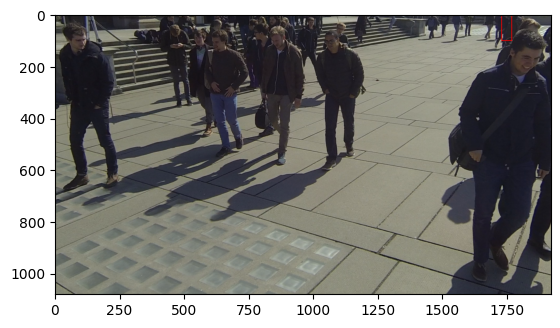

In [10]:
import matplotlib.pyplot as plt
img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
plt.imshow(img)
plt.show()